<a href="https://colab.research.google.com/github/nguyen-nhat-mai/ensemble_project/blob/main/Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIRBNB PRICE PREDICTION**
By Mengyu LIANG, Nhat Mai NGUYEN, Jinji SHEN and Vanshika SHARMA

# **Setup**

In [3]:
# Please upload your kaggle.json file before running this cell
! pip install kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 63.3MB/s]


In [5]:
! unzip /content/new-york-city-airbnb-open-data.zip

Archive:  /content/new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [6]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.3 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# **Data Exploration**

**Initial check**

In [14]:
# load dataset
df = pd.read_csv('/content/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [15]:
df.shape

(48895, 16)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [17]:
# check null value
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [18]:
# check duplicate
df.duplicated().sum()

0

In [19]:
# check numerical variables
num_var = ['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','price']
df[num_var].describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
count,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,7.029962,23.274466,1.373221,7.143982,112.781327,152.720687
std,0.054530,0.046157,20.510550,44.550582,1.680442,32.952519,131.622289,240.154170
min,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,40.690100,-73.983070,1.000000,1.000000,0.190000,1.000000,0.000000,69.000000
50%,40.723070,-73.955680,3.000000,5.000000,0.720000,1.000000,45.000000,106.000000
75%,40.763115,-73.936275,5.000000,24.000000,2.020000,2.000000,227.000000,175.000000
max,40.913060,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000,10000.000000


In [20]:
# check categorical variables (unique values, format consistency such as lower/uppercase, space,...)
print('Unique values per variable')
print(df[['name','host_name','neighbourhood_group','neighbourhood','room_type']].nunique())
print('\nUnique values in neighbourhood_group', df['neighbourhood_group'].unique())
print('Unique values in room_type', df['room_type'].unique())

Unique values per variable
name                   47905
host_name              11452
neighbourhood_group        5
neighbourhood            221
room_type                  3
dtype: int64

Unique values in neighbourhood_group ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Unique values in room_type ['Private room' 'Entire home/apt' 'Shared room']


**Target variable: Price**

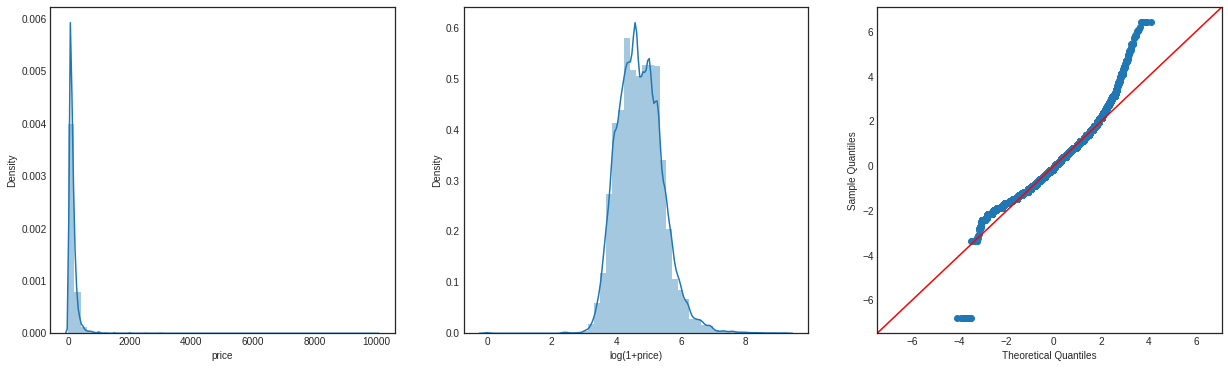

In [21]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(df['price'], ax=axes[0])
sns.distplot(np.log1p(df['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(df['price']), stats.norm, fit=True, line='45', ax=axes[2])
plt.show()

The distribution of price is highly skewed. By taking log, the variable seems to follow normal distribution.

In [22]:
df['log_price'] = np.log1p(df['price'])

**Distribution of other numerical variables**

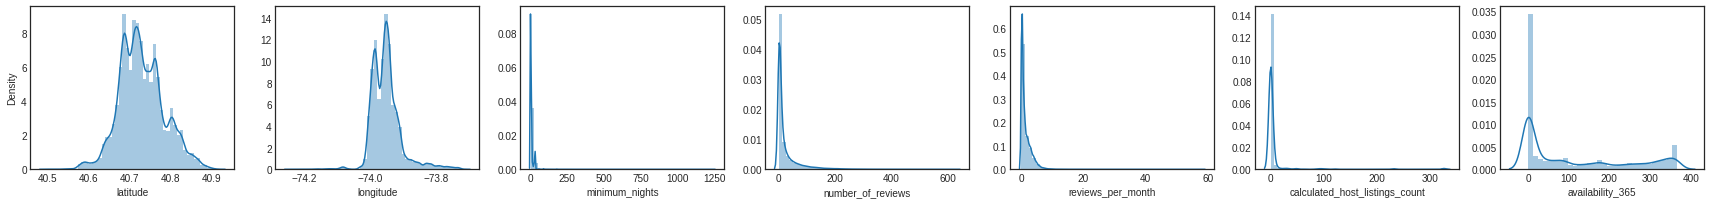

In [25]:
filter_num_var = num_var[:-1] # exclude price
f,ax = plt.subplots(1,7, figsize=(30,3))
for i in range(len(filter_num_var)):
  sns.distplot(df[filter_num_var[i]], ax=ax[i])
  ax[i].set_xlabel(filter_num_var[i])
  if i > 0:
    ax[i].set(ylabel=None)

Except for latitude and longtitude, distributions of the remaining variables are highly skewed

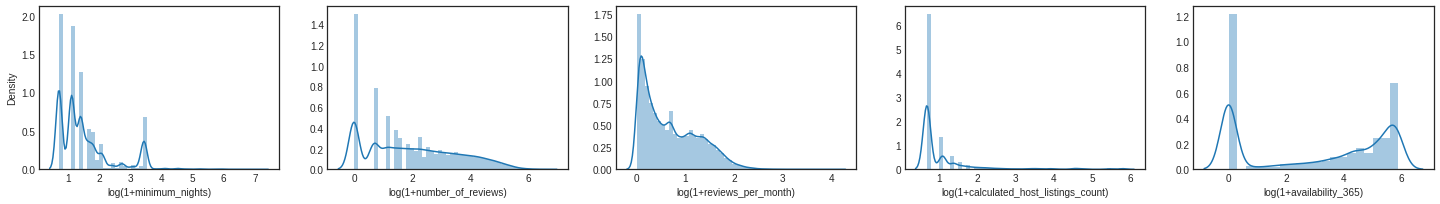

In [27]:
skewed_var = ['minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
f,ax = plt.subplots(1,5, figsize=(25,3))
for i in range(len(skewed_var)):
  sns.distplot(np.log1p(df[skewed_var[i]]), ax=ax[i])
  ax[i].set_xlabel("log(1+"+ skewed_var[i]+")")
  if i > 0:
    ax[i].set(ylabel=None)

The data are too skewed that log transformation can not normalize the them. However, we can add these as potential features for trial & error in modeling part.

In [39]:
# Add log variables
df['log_minimum_nights'] = np.log1p(df['minimum_nights'])
df['log_number_of_reviews'] = np.log1p(df['number_of_reviews'])
df['log_reviews_per_month'] = np.log1p(df['reviews_per_month'])
df['log_calculated_host_listings_count'] = np.log1p(df['calculated_host_listings_count'])
df['log_availability_365'] = np.log1p(df['availability_365'])

Besides, since the variables are highly concentrated in certain values, other yes/no features such as no_review, fully_available, low_available, etc. can be extracted for trial and error as well.

In [29]:
# Add yes/no (1/0) variables
df['no_review'] = np.where(df['reviews_per_month'] > 0, 0, 1) # place without a review
df['minimum_night_1'] = np.where(df['minimum_nights'] == 1, 1, 0) # places requires minimum night of 1
df['host_listing_1'] = np.where(df['calculated_host_listings_count'] == 1, 1, 0) # host list only 1 place
df['availability_full'] = np.where(df['availability_365'] == 365, 1, 0) # availability = 365
df['availability_low'] = np.where(df['availability_365'] < 12, 1, 0) # available less than 1 day/month
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price,no_review,minimum_night_1,host_listing_1,availability_full,availability_low
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,2018-10-19,0.21,6,365,5.010635,0,1,0,1,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2019-05-21,0.38,2,355,5.420535,0,1,0,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,NaN,NaN,1,365,5.017280,1,0,1,1,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,2019-07-05,4.64,1,194,4.499810,0,1,1,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,2018-11-19,0.10,1,0,4.394449,0,0,1,0,1


**A map view of price distribution**

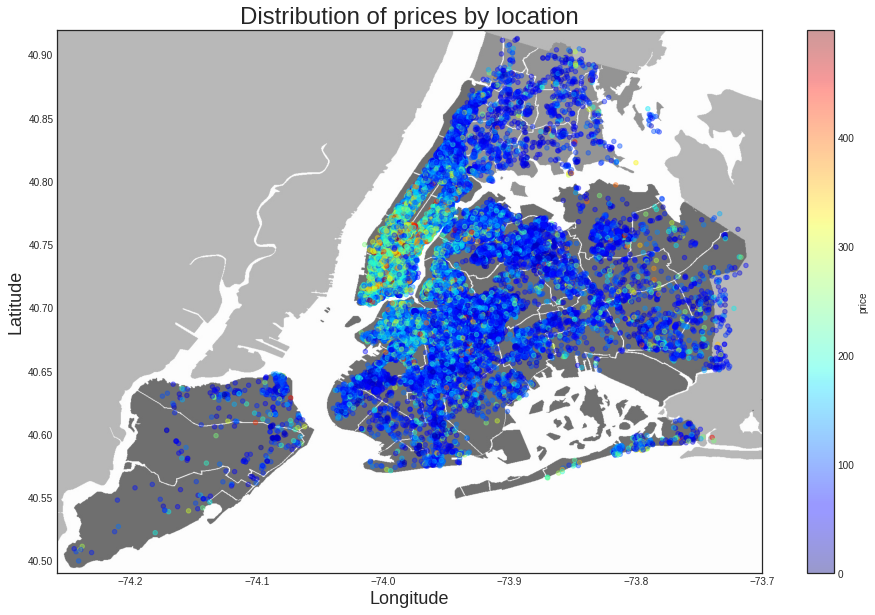

In [30]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("/content/New_York_City_.png", 0) # without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
df[df.price < 500].plot(kind='scatter', x='longitude', y='latitude', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of prices by location', fontsize= 24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)

plt.show()

**A map view of the availability**

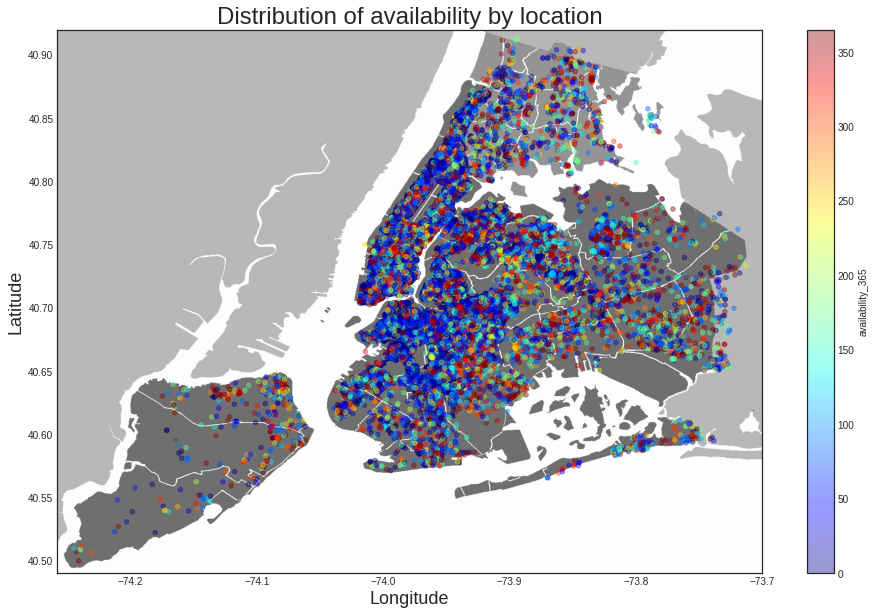

In [31]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("/content/New_York_City_.png", 0) #without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
df[df.availability_365>= 0].plot(kind='scatter', x='longitude', y='latitude', c='availability_365', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of availability by location', fontsize=24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.show()

**Neighbourhood Groups**

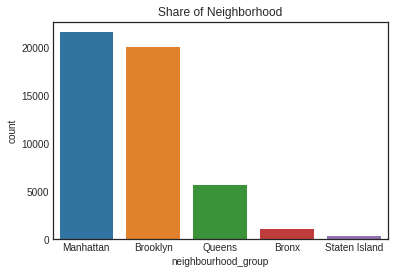

In [32]:
# visualize the number of Airbnbs in each borough
ax = sns.countplot('neighbourhood_group',data=df,order=df['neighbourhood_group'].value_counts().index)
ax.set_title('Share of Neighborhood')
plt.show()

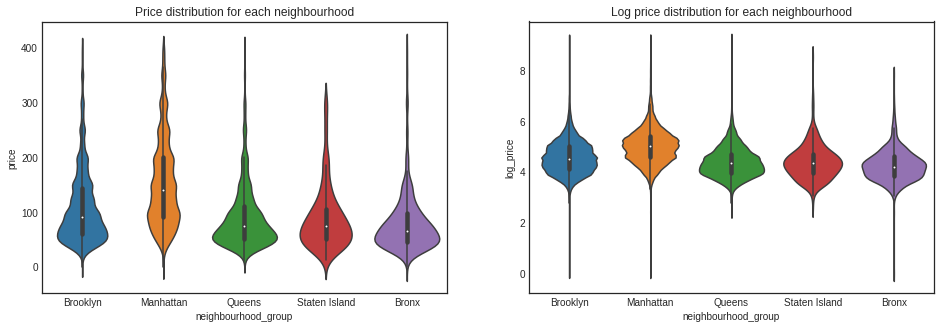

In [33]:
# create a sub-dataframe with no extreme values /
winsorized_df = df[df.price < 400]

# using violinplot to showcase density and distribtuion of prices
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.violinplot(data=winsorized_df, x='neighbourhood_group', y='price', ax=ax[0])
ax[0].set_title('Price distribution for each neighbourhood')
sns.violinplot(data=df, x='neighbourhood_group', y='log_price', ax=ax[1])
ax[1].set_title('Log price distribution for each neighbourhood')
plt.show()

We can see that Manhattan seems to have more of the higher priced properties. Bronx, Staten Island, and Queens have much more reasonable prices compared to Brooklyn and Manhattan. All distributions of price have positive skew while distributions of log(price) are quite normal.

**Room Type**

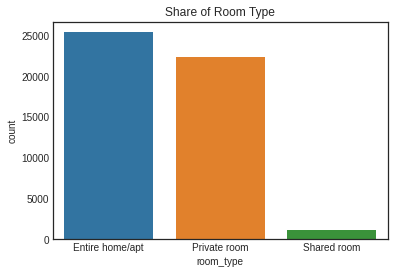

In [34]:
ax = sns.countplot('room_type',data=df,order=df['room_type'].value_counts().index)
ax.set_title('Share of Room Type')
plt.show()

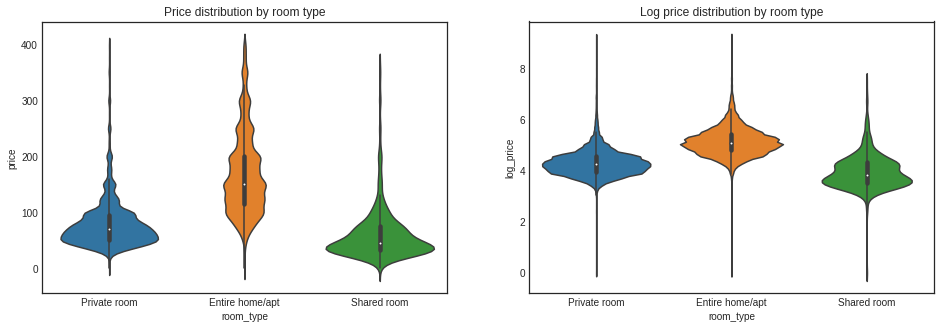

In [35]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.violinplot(data=winsorized_df, x='room_type', y='price',ax=ax[0])
ax[0].set_title('Price distribution by room type')
sns.violinplot(data=df, x='room_type', y='log_price',ax=ax[1])
ax[1].set_title('Log price distribution by room type')
plt.show()

As expected, shared rooms have the lowest mean price, while entire homes have the highest. All room types seem to have a similar spread, however private rooms and shared rooms seemd to be more centered around their mean. There is more disparity of price with entire homes.

**Variable Correlations**

In [36]:
df.corr().style.background_gradient(cmap='coolwarm')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price,no_review,minimum_night_1,host_listing_1,availability_full,availability_low
id,1.000000,0.588290,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.291828,0.133272,0.085468,-0.015395,0.164785,0.047127,-0.117694,0.005779,-0.197884
host_id,0.588290,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.296417,0.154950,0.203492,-0.016690,0.084543,0.124534,-0.140426,0.037615,-0.238412
latitude,-0.003125,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.010142,0.019517,-0.010983,0.079339,0.029387,0.020154,0.014829,0.000198,0.019058
longitude,0.090908,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.145948,-0.114713,0.082731,-0.325043,-0.043506,0.108033,-0.105213,0.031785,-0.107916
price,0.010619,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829,0.637669,0.085151,-0.026415,0.034611,0.067343,-0.059028
minimum_nights,-0.013224,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303,0.033185,0.111360,-0.174334,-0.074065,0.101087,-0.096201
number_of_reviews,-0.319760,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028,-0.042801,-0.265767,0.078097,-0.089469,-0.048330,-0.253268
reviews_per_month,0.291828,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791,-0.039487,nan,0.239697,-0.128453,-0.047865,-0.350789
calculated_host_listings_count,0.133272,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701,0.132274,0.118088,-0.084971,-0.260158,0.030105,-0.141722
availability_365,0.085468,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000,0.098558,-0.031387,0.001632,-0.359167,0.316070,-0.717890


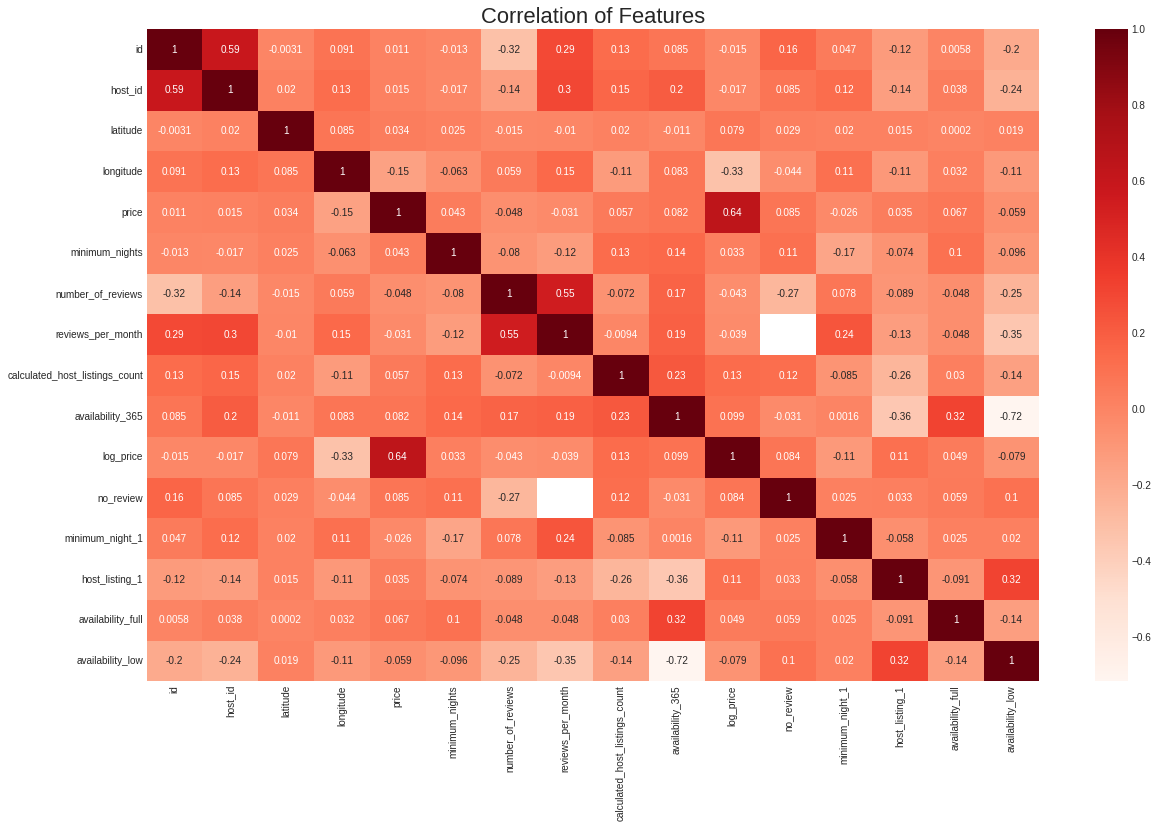

In [37]:
plt.figure(figsize=(20,12))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation of Features", fontsize = 22)
plt.show()

# **Data Pre-processing**

**Deal with missing values**

In [40]:
# impute the null values in reviews_per_month and log__review_per_month with zero
df['reviews_per_month'].fillna(value=0, inplace=True)
print('Reviews_per_month column with null values:',df['reviews_per_month'].isnull().sum(), sep = '\n')
df['log_reviews_per_month'].fillna(value=0, inplace=True)
print('Log_Reviews_per_month column with null values:',df['log_reviews_per_month'].isnull().sum(), sep = '\n')

Reviews_per_month column with null values:
0
Log_Reviews_per_month column with null values:
0


In [41]:
# drop unwwanted features
df.drop(['id','host_name','last_review'], axis = 1,inplace=True) 
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,no_review,minimum_night_1,host_listing_1,availability_full,availability_low,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count,log_availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,...,0,1,0,1,0,0.693147,2.302585,0.190620,1.945910,5.902633
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,...,0,1,0,0,0,0.693147,3.828641,0.322083,1.098612,5.874931
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,...,1,0,1,1,0,1.386294,0.000000,0.000000,0.693147,5.902633
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,...,0,1,1,0,0,0.693147,5.602119,1.729884,0.693147,5.273000
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,...,0,0,1,0,1,2.397895,2.302585,0.095310,0.693147,0.000000


**Deal with outliers**

Text(0.5, 1.0, 'host listings count')

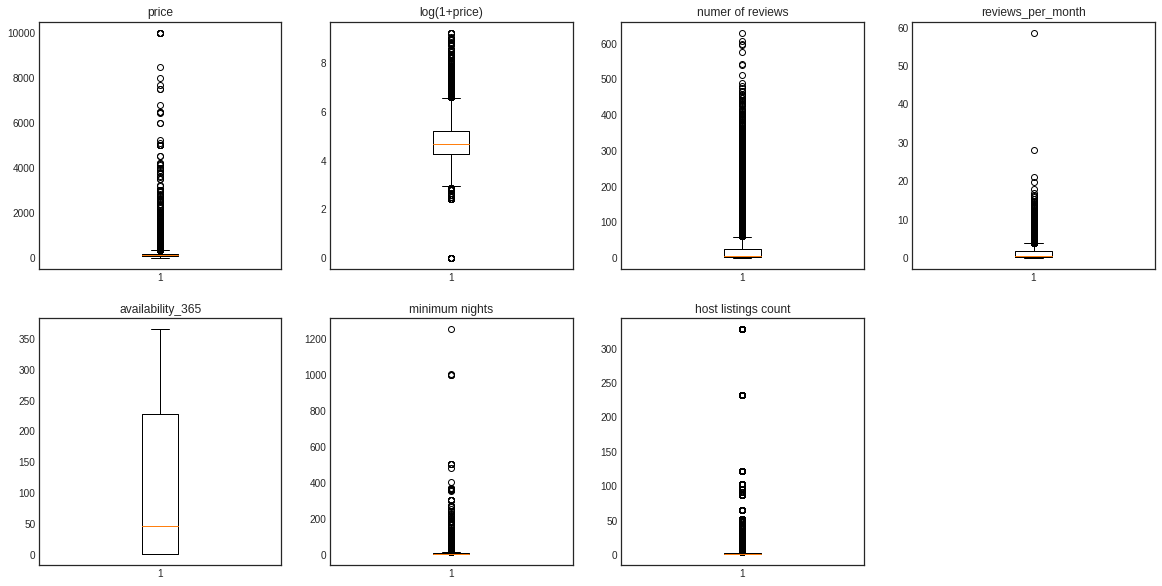

In [43]:
# visualize data and check outliers
plt.figure(figsize = (20, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(241)
plt.boxplot(df['price'])
ax.set_title('price')
ax=plt.subplot(242)
plt.boxplot(df['log_price'])
ax.set_title('log(1+price)')
ax=plt.subplot(243)
plt.boxplot(df['number_of_reviews'])
ax.set_title('numer of reviews')
ax=plt.subplot(244)
plt.boxplot(df['reviews_per_month'])
ax.set_title('reviews_per_month')
ax=plt.subplot(245)
plt.boxplot(df['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(246)
plt.boxplot(df['minimum_nights'])
ax.set_title('minimum nights')
ax=plt.subplot(247)
plt.boxplot(df['calculated_host_listings_count'])
ax.set_title('host listings count')

Normally, any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. In this case, we can see that except availability_365, all other numerical factors have the huge amount of outliers. However, such huge amount of outliers sometimes can be useful info that reflect the underlying distribution. For the log_price - the target variable that we will use, 22% belongs to "outlier" category and this proportion is tremendous. So we would love to create 2 scenarios to test out:


1.   Consider such 22% data as outliers => remove them
2.  Consider such 22% data as useful info for prediction => keep them



In [44]:
# remove outliers
Q1 = df['log_price'].quantile(0.25)
Q3 = df['log_price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df['log_price'] >= Q1 - 1.5 * IQR) & (df['log_price'] <= Q3 + 1.5 *IQR)
df1 = df.loc[filter]

Q1 = df1['number_of_reviews'].quantile(0.25)
Q3 = df1['number_of_reviews'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df1['number_of_reviews'] >= Q1 - 1.5 * IQR) & (df1['number_of_reviews'] <= Q3 + 1.5 *IQR)
df2 = df1.loc[filter]

Q1 = df2['reviews_per_month'].quantile(0.25)
Q3 = df2['reviews_per_month'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df2['reviews_per_month'] >= Q1 - 1.5 * IQR) & (df2['reviews_per_month'] <= Q3 + 1.5 *IQR)
df_wo_outlier = df2.loc[filter]

In [45]:
# check % data removed
1-len(df_wo_outlier)/len(df)

0.22120871254729524

Text(0.5, 1.0, 'host listings count')

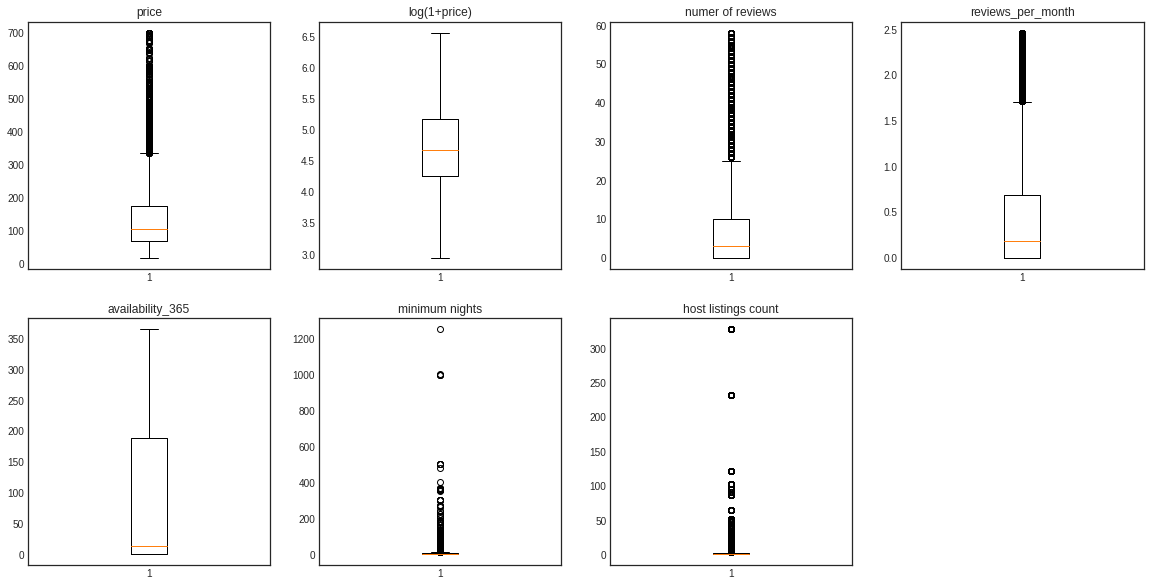

In [47]:
# check outliers again
plt.figure(figsize = (20, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(241)
plt.boxplot(df_wo_outlier['price'])
ax.set_title('price')
ax=plt.subplot(242)
plt.boxplot(df_wo_outlier['log_price'])
ax.set_title('log(1+price)')
ax=plt.subplot(243)
plt.boxplot(df_wo_outlier['number_of_reviews'])
ax.set_title('numer of reviews')
ax=plt.subplot(244)
plt.boxplot(df_wo_outlier['reviews_per_month'])
ax.set_title('reviews_per_month')
ax=plt.subplot(245)
plt.boxplot(df_wo_outlier['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(246)
plt.boxplot(df_wo_outlier['minimum_nights'])
ax.set_title('minimum nights')
ax=plt.subplot(247)
plt.boxplot(df_wo_outlier['calculated_host_listings_count'])
ax.set_title('host listings count')

**Convert categorical data**

In [48]:
def encode_cat_var(df):
  ''' Input: dataframe containing 2 categorical variables: neighbourhood_group, room_type
      Output: feature dataframe with 1 hot encoded values of such categorical variables
  '''
  # one hot encoding
  dummy_neighbourhood=pd.get_dummies(df['neighbourhood_group'], prefix='dummy')
  dummy_roomtype=pd.get_dummies(df['room_type'], prefix='dummy')
  # get the feature column names
  col_names = list(df.columns)
  target_names = {'price', 'log_price'}
  feature_names = [ele for ele in col_names if ele not in target_names]
  # create dataframe with encoding values
  encoded_features = df[feature_names]
  encoded_features = pd.concat([encoded_features,dummy_neighbourhood,dummy_roomtype],axis=1)
  encoded_features.drop(['neighbourhood_group','room_type','name','neighbourhood'],axis=1, inplace=True)
  return encoded_features

In [49]:
# Encoding df
feature_df = encode_cat_var(df)
feature_df.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,no_review,minimum_night_1,...,log_calculated_host_listings_count,log_availability_365,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,2787,40.64749,-73.97237,1,9,0.21,6,365,0,1,...,1.945910,5.902633,0,1,0,0,0,0,1,0
1,2845,40.75362,-73.98377,1,45,0.38,2,355,0,1,...,1.098612,5.874931,0,0,1,0,0,1,0,0
2,4632,40.80902,-73.94190,3,0,0.00,1,365,1,0,...,0.693147,5.902633,0,0,1,0,0,0,1,0
3,4869,40.68514,-73.95976,1,270,4.64,1,194,0,1,...,0.693147,5.273000,0,1,0,0,0,1,0,0
4,7192,40.79851,-73.94399,10,9,0.10,1,0,0,0,...,0.693147,0.000000,0,0,1,0,0,1,0,0


In [50]:
# Encoding df without outliers
feature_df_wo_outlier = encode_cat_var(df_wo_outlier)
feature_df_wo_outlier.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,no_review,minimum_night_1,...,log_calculated_host_listings_count,log_availability_365,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,2787,40.64749,-73.97237,1,9,0.21,6,365,0,1,...,1.945910,5.902633,0,1,0,0,0,0,1,0
1,2845,40.75362,-73.98377,1,45,0.38,2,355,0,1,...,1.098612,5.874931,0,0,1,0,0,1,0,0
2,4632,40.80902,-73.94190,3,0,0.00,1,365,1,0,...,0.693147,5.902633,0,0,1,0,0,0,1,0
4,7192,40.79851,-73.94399,10,9,0.10,1,0,0,0,...,0.693147,0.000000,0,0,1,0,0,1,0,0
6,7356,40.68688,-73.95596,45,49,0.40,1,0,0,0,...,0.693147,0.000000,0,1,0,0,0,0,1,0


**Standardize the dataset**

In [51]:
def normalize_features(feature_df):
  ''' Input: dataframe of features
      Output: dataframe of features with normalized values
  '''
  # normalize the data
  X = preprocessing.scale(feature_df)
  # convert normalized data array into dataframe
  X = pd.DataFrame(X)
  col_name_map = {k: v for k, v in enumerate(list(feature_df.columns))}
  X=X.rename(index=str, columns=col_name_map)
  return X

In [52]:
# Normalize feature_df
feature_df = normalize_features(feature_df)
feature_df.head()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,no_review,minimum_night_1,...,log_calculated_host_listings_count,log_availability_365,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,-0.860159,-1.493849,-0.437652,-0.293996,-0.320414,-0.551511,-0.034716,1.916250,-0.508710,1.686400,...,1.000041,1.181201,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,-1.040134,1.090893,-0.155887
1,-0.860158,0.452436,-0.684639,-0.293996,0.487665,-0.445079,-0.156104,1.840275,-0.508710,1.686400,...,0.013273,1.169951,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.961415,-0.916680,-0.155887
2,-0.860135,1.468399,0.222497,-0.196484,-0.522433,-0.682986,-0.186451,1.916250,1.965758,-0.592979,...,-0.458935,1.181201,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,-1.040134,1.090893,-0.155887
3,-0.860132,-0.803398,-0.164450,-0.293996,5.538156,2.221978,-0.186451,0.617065,-0.508710,1.686400,...,-0.458935,0.925502,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.961415,-0.916680,-0.155887
4,-0.860103,1.275660,0.177216,0.144807,-0.320414,-0.620379,-0.186451,-0.856865,-0.508710,-0.592979,...,-0.458935,-1.215905,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.961415,-0.916680,-0.155887


In [53]:
# Normalize feature_df without the outliers
feature_df_wo_outlier = normalize_features(feature_df_wo_outlier)
feature_df_wo_outlier.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,no_review,minimum_night_1,...,log_calculated_host_listings_count,log_availability_365,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,-0.841170,-1.508363,-0.421415,-0.314694,0.066561,-0.408292,-0.057382,2.016157,-0.587186,1.827562,...,0.920617,1.316403,-0.14328,1.188039,-0.907198,-0.346225,-0.082108,-1.034008,1.086073,-0.158397
1,-0.841169,0.448921,-0.681608,-0.314694,3.041601,-0.121548,-0.171971,1.940206,-0.587186,1.827562,...,-0.002151,1.305361,-0.14328,-0.841723,1.102295,-0.346225,-0.082108,0.967110,-0.920748,-0.158397
2,-0.841145,1.470626,0.274033,-0.225428,-0.677199,-0.762506,-0.200618,2.016157,1.703038,-0.547177,...,-0.443731,1.316403,-0.14328,-0.841723,1.102295,-0.346225,-0.082108,-1.034008,1.086073,-0.158397
3,-0.841112,1.276797,0.226331,0.087006,0.066561,-0.593832,-0.200618,-0.756042,-0.587186,-0.547177,...,-0.443731,-1.036356,-0.14328,-0.841723,1.102295,-0.346225,-0.082108,0.967110,-0.920748,-0.158397
4,-0.841110,-0.781920,-0.046873,1.649171,3.372161,-0.087813,-0.200618,-0.756042,-0.587186,-0.547177,...,-0.443731,-1.036356,-0.14328,1.188039,-0.907198,-0.346225,-0.082108,-1.034008,1.086073,-0.158397


In [54]:
# Get the target variables
y = df.log_price
print(y)
y_wo_outlier = df_wo_outlier.log_price
print(y_wo_outlier)

# check length of features & target variables
if len(feature_df) == len(y):
  print("check 1:",True)
else: 
  print(False)

if len(feature_df_wo_outlier) == len(y_wo_outlier):
  print("check 2:", True)
else: 
  print(False)

0        5.010635
1        5.420535
2        5.017280
3        4.499810
4        4.394449
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: log_price, Length: 48895, dtype: float64
0        5.010635
1        5.420535
2        5.017280
4        4.394449
6        4.110874
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: log_price, Length: 38079, dtype: float64
check 1: True
check 2: True


**Feature importance**

In [55]:
X = feature_df.to_numpy()
X_wo_outlier = feature_df_wo_outlier.to_numpy()

In [58]:
# random forest for feature importance on a regression problem
def feature_imp_rf(feature_name_list, X , y):
  ''' Input: list of feature names, feature values, target values
      Output: importance score for each feature
  '''
  # get the model
  model = RandomForestRegressor()
  model.fit(X, y)
  # get importance
  importance = model.feature_importances_
  # summarize feature importance
  for i,v in enumerate(importance):
    feature_name = feature_name_list[i]
    print('Feature {} ({}): Score: {}'.format(i,feature_name,v))
  # plot feature importance
  plt.bar([x for x in range(len(importance))], importance)
  plt.show()

Feature 0 (host_id): Score: 0.0802254156500407
Feature 1 (latitude): Score: 0.12739208549937608
Feature 2 (longitude): Score: 0.1367536975725734
Feature 3 (minimum_nights): Score: 0.023167256309514137
Feature 4 (number_of_reviews): Score: 0.017921270421622726
Feature 5 (reviews_per_month): Score: 0.023533308723776236
Feature 6 (calculated_host_listings_count): Score: 0.013304806022614257
Feature 7 (availability_365): Score: 0.03529180835378325
Feature 8 (no_review): Score: 0.002993421741859132
Feature 9 (minimum_night_1): Score: 0.0031241531066754273
Feature 10 (host_listing_1): Score: 0.0031422345155111674
Feature 11 (availability_full): Score: 0.0006877769744960717
Feature 12 (availability_low): Score: 0.0009878534104226955
Feature 13 (log_minimum_nights): Score: 0.023721341312219694
Feature 14 (log_number_of_reviews): Score: 0.01827438832675922
Feature 15 (log_reviews_per_month): Score: 0.02331437980579494
Feature 16 (log_calculated_host_listings_count): Score: 0.013211177657146335


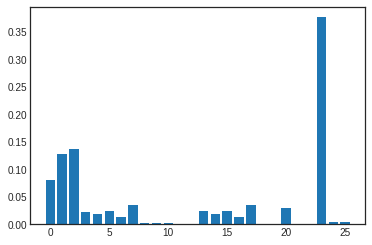

In [59]:
# check feature importance
feature_imp_rf(list(feature_df.columns),X,y)

Feature 0 (host_id): Score: 0.07456747008337633
Feature 1 (latitude): Score: 0.12547686131670585
Feature 2 (longitude): Score: 0.12875497137639416
Feature 3 (minimum_nights): Score: 0.02265842732353087
Feature 4 (number_of_reviews): Score: 0.015141743209711993
Feature 5 (reviews_per_month): Score: 0.021576303359394332
Feature 6 (calculated_host_listings_count): Score: 0.0116191834325558
Feature 7 (availability_365): Score: 0.029405889034403016
Feature 8 (no_review): Score: 0.0017561772126444928
Feature 9 (minimum_night_1): Score: 0.002582488434597433
Feature 10 (host_listing_1): Score: 0.003097179173418079
Feature 11 (availability_full): Score: 0.0005541890558375895
Feature 12 (availability_low): Score: 0.0010319906378323408
Feature 13 (log_minimum_nights): Score: 0.022049983500750842
Feature 14 (log_number_of_reviews): Score: 0.015634661943826674
Feature 15 (log_reviews_per_month): Score: 0.021408857923439016
Feature 16 (log_calculated_host_listings_count): Score: 0.012122540567436193

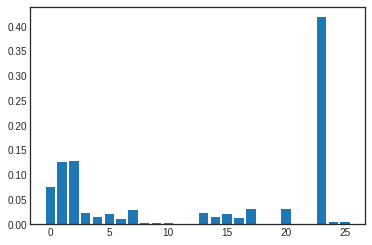

In [60]:
# check feature importance for data without outliers
feature_imp_rf(list(feature_df.columns),X_wo_outlier,y_wo_outlier)

From these feature dataframes, the target variable and hints on feature importance, we can test out 2 scenarios with different combination of features.


# **Modeling**

# Scenario 1: outliers are not removed

### Decision Trees

#### Model with all features

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
dtr = DecisionTreeRegressor(min_samples_leaf=.01)
dtr.fit(X_train,y_train)
np.mean(cross_val_score(dtr,X_train,y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-0.3369607593220844

In [62]:
pred_dtr = dtr.predict(X_test)
mae_dtr_all = mean_absolute_error(y_test, pred_dtr)
rmse_dtr_all = np.sqrt(mean_squared_error(y_test, pred_dtr))
r2_dtr_all = r2_score(y_test, pred_dtr)
print('MAE: %f' % mae_dtr_all)
print('RMSE: %f' % rmse_dtr_all)
print('R2: %f' % r2_dtr_all)

MAE: 0.343125
RMSE: 0.484521
R2: 0.525574


In [63]:
# Desicion Tree with GridSearchCV -- parameter tuning

depths = np.arange(1,10)
num_leafs = np.arange(1,10)
dt_parameters = [{'max_depth' : depths,
                  'min_samples_leaf' : num_leafs}]

dt_gs = GridSearchCV(DecisionTreeRegressor(), dt_parameters, scoring = 'neg_mean_absolute_error',cv = 3)
dt_gs.fit(X_train,y_train)

dt_gs.best_score_ 
dt_gs.best_estimator_

DecisionTreeRegressor(max_depth=8, min_samples_leaf=9)

In [64]:
pred_dtr_gs = dt_gs.best_estimator_.predict(X_test)
mae_dtr_gs_all = mean_absolute_error(y_test, pred_dtr_gs)
rmse_dtr_gs_all = np.sqrt(mean_squared_error(y_test, pred_dtr_gs))
r2_dtr_gs_all = r2_score(y_test, pred_dtr_gs)
print('MAE: %f' % mae_dtr_gs_all)
print('RMSE: %f' % rmse_dtr_gs_all)
print('R2: %f' % r2_dtr_gs_all)

MAE: 0.335673
RMSE: 0.476415
R2: 0.541314


#### Model with important features

In [65]:
X_pick=feature_df[['host_id','latitude','longitude','dummy_Entire home/apt']].to_numpy()
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_pick, y, test_size=0.3, random_state=3)

In [66]:
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
dt_parameters = [{'max_depth' : depths,
                  'min_samples_leaf' : num_leafs}]

dt_gs = GridSearchCV(DecisionTreeRegressor(), dt_parameters, scoring = 'neg_mean_absolute_error',cv = 3)
dt_gs.fit(X_train_new,y_train_new)

pred_dtr_gs_new = dt_gs.best_estimator_.predict(X_test_new)

In [67]:
mae_dtr_imp = mean_absolute_error(y_test_new, pred_dtr_gs_new)
rmse_dtr_imp = np.sqrt(mean_squared_error(y_test_new, pred_dtr_gs_new))
r2_dtr_imp = r2_score(y_test_new, pred_dtr_gs_new)
print('MAE: %f' % mae_dtr_imp)
print('RMSE: %f' % rmse_dtr_imp)
print('R2: %f' % r2_dtr_imp)

MAE: 0.353444
RMSE: 0.498569
R2: 0.497664


### Random Forest 

#### Model with all features

In [68]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-0.3109494414905661

In [69]:
pred_rf = rf.predict(X_test)
mae_rf_all = mean_absolute_error(y_test, pred_rf)
rmse_rf_all = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf_all = r2_score(y_test, pred_rf)
print('MAE: %f' % mae_rf_all)
print('RMSE: %f' % rmse_rf_all)
print('R2: %f' % r2_rf_all)

MAE: 0.312453
RMSE: 0.446429
R2: 0.597238


In [70]:
# parameter tuning

num_estimators = np.arange(1,10)
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
max_features = ['auto', 'log2', 'sqrt']
rf_parameters = [{
                 'n_estimators': num_estimators,
                 'max_depth' : depths,
                 'min_samples_leaf' : num_leafs,
                 'max_features' : max_features}]

rf_gs = GridSearchCV(RandomForestRegressor(), rf_parameters, scoring = 'neg_mean_absolute_error', cv = 3)
rf_gs.fit(X_train,y_train)

print(rf_gs.best_score_ )
print(rf_gs.best_estimator_)
pred_rf_gs = rf_gs.best_estimator_.predict(X_test)

-0.31691047786228954
RandomForestRegressor(max_depth=9, max_features='auto', min_samples_leaf=6,
                      n_estimators=8)


In [71]:
mae_rf_gs_all = mean_absolute_error(y_test, pred_rf_gs)
rmse_rf_gs_all = np.sqrt(mean_squared_error(y_test, pred_rf_gs))
r2_rf_gs_all = r2_score(y_test, pred_rf_gs)
print('MAE: %f' % mae_rf_gs_all)
print('RMSE: %f' % rmse_rf_gs_all)
print('R2: %f' % r2_rf_gs_all)

MAE: 0.323396
RMSE: 0.460182
R2: 0.572041


#### Model with important features

In [72]:
num_estimators = np.arange(1,10)
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
max_features = ['auto', 'log2', 'sqrt']
rf_parameters = [{
                 'n_estimators': num_estimators,
                 'max_depth' : depths,
                 'min_samples_leaf' : num_leafs,
                 'max_features' : max_features}]

rf_gs = GridSearchCV(RandomForestRegressor(), rf_parameters, scoring = 'neg_mean_absolute_error', cv = 3)
rf_gs.fit(X_train_new,y_train_new)
pred_rf_gs_new = rf_gs.best_estimator_.predict(X_test_new)

In [73]:
mae_rf_imp = mean_absolute_error(y_test_new, pred_rf_gs_new)
rmse_rf_imp = np.sqrt(mean_squared_error(y_test_new, pred_rf_gs_new))
r2_rf_imp = r2_score(y_test_new, pred_rf_gs_new)
print('MAE: %f' % mae_rf_imp)
print('RMSE: %f' % rmse_rf_imp)
print('R2: %f' % r2_rf_imp)

MAE: 0.345551
RMSE: 0.488603
R2: 0.517546


###AdaBoost

####Model with all features

In [74]:
# Creating an AdaBoost regressor using decision trees as the base estimator
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), n_estimators=100, learning_rate=0.1, random_state=3)

# Fit the regressor to the training data
ada_reg.fit(X_train, y_train)

#cross-validation
np.mean(cross_val_score(ada_reg,X_train,y_train,scoring = 'neg_mean_absolute_error', cv=3))

#Making predictions
pred_ada_reg = ada_reg.predict(X_test)

In [75]:
mae_ada_all = mean_absolute_error(y_test, pred_ada_reg)
rmse_ada_all = np.sqrt(mean_squared_error(y_test, pred_ada_reg))
r2_ada_all = r2_score(y_test, pred_ada_reg)
print('MAE: %f' % mae_ada_all)
print('RMSE: %f' % rmse_ada_all)
print('R2: %f' % r2_ada_all)

MAE: 0.380532
RMSE: 0.515302
R2: 0.463380


In [76]:
#With GridSearchCV

# Define the AdaBoost regressor to use
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), random_state=3)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(ada_reg, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)

# Print the best hyperparameters and corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: {:.2f}".format(-grid_search.best_score_))

# Make predictions on the test data using the best estimator found by grid search
best_ada_reg = grid_search.best_estimator_
pred_ada_reg_gs = best_ada_reg.predict(X_test)

Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 200}
Best Score: 0.24


In [77]:
mae_ada_gs_all = mean_absolute_error(y_test, pred_ada_reg_gs)
rmse_ada_gs_all = np.sqrt(mean_squared_error(y_test, pred_ada_reg_gs))
r2_ada_gs_all = r2_score(y_test, pred_ada_reg_gs)
print('MAE: %f' % mae_ada_gs_all)
print('RMSE: %f' % rmse_ada_gs_all)
print('R2: %f' % r2_ada_gs_all)

MAE: 0.368560
RMSE: 0.512115
R2: 0.469997


####Model with important features

In [78]:
# Perform grid search with cross-validation
grid_search2 = GridSearchCV(ada_reg, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search2.fit(X_train_new,y_train_new)

# Print the best hyperparameters and corresponding score
print("Best Parameters: ", grid_search2.best_params_)
print("Best Score: {:.2f}".format(-grid_search2.best_score_))

# Make predictions on the test data using the best estimator found by grid search
best_ada_reg2 = grid_search2.best_estimator_
pred_ada_reg_gs2 = best_ada_reg2.predict(X_test_new)

Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 100}
Best Score: 0.25


In [79]:
mae_ada_gs_imp = mean_absolute_error(y_test_new, pred_ada_reg_gs2)
rmse_ada_gs_imp = np.sqrt(mean_squared_error(y_test_new, pred_ada_reg_gs2))
r2_ada_gs_imp = r2_score(y_test_new, pred_ada_reg_gs2)
print('MAE: %f' % mae_ada_gs_imp)
print('RMSE: %f' % rmse_ada_gs_imp)
print('R2: %f' % r2_ada_gs_imp)

MAE: 0.369397
RMSE: 0.514673
R2: 0.464690


###Gradient Boosting

####Model with all features

In [80]:
# Define the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=3)

# Define the parameters to search
params_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 1.0],
    'min_samples_split': [2, 3, 4]
}

# Define the GridSearchCV object
grid_search_gb = GridSearchCV(estimator=gb_regressor, param_grid=params_gb, cv=3)

# Train the model with GridSearchCV
grid_search_gb.fit(X_train,y_train)

# Get the best parameters and the best score
best_params = grid_search_gb.best_params_
best_score = grid_search_gb.best_score_

In [81]:
# Use the best parameters to train a new model
best_gb_regressor = GradientBoostingRegressor(**best_params, random_state=3)
best_gb_regressor.fit(X_train, y_train)

#Making predictions
pred_gb = best_gb_regressor.predict(X_test)

In [82]:
mae_gb_all = mean_absolute_error(y_test, pred_gb)
rmse_gb_all = np.sqrt(mean_squared_error(y_test, pred_gb))
r2_gb_all = r2_score(y_test, pred_gb)
print('MAE: %f' % mae_gb_all)
print('RMSE: %f' % rmse_gb_all)
print('R2: %f' % r2_gb_all)

MAE: 0.317675
RMSE: 0.452259
R2: 0.586651


####Model with important features

In [83]:
# Define the GridSearchCV object
grid_search_gb2 = GridSearchCV(estimator=gb_regressor, param_grid=params_gb, cv=3)

# Train the model with GridSearchCV
grid_search_gb2.fit(X_train_new,y_train_new)

# Get the best parameters and the best score
best_params2 = grid_search_gb2.best_params_
best_score = grid_search_gb2.best_score_

In [84]:
# Use the best parameters to train a new model
best_gb_regressor2 = GradientBoostingRegressor(**best_params2, random_state=3)
best_gb_regressor2.fit(X_train_new, y_train_new)

#Making predictions
pred_gb2 = best_gb_regressor2.predict(X_test_new)

In [85]:
mae_gb_imp = mean_absolute_error(y_test_new, pred_gb2)
rmse_gb_imp = np.sqrt(mean_squared_error(y_test_new, pred_gb2))
r2_gb_imp = r2_score(y_test_new, pred_gb2)
print('MAE: %f' % mae_gb_imp)
print('RMSE: %f' % rmse_gb_imp)
print('R2: %f' % r2_gb_imp) 

MAE: 0.345325
RMSE: 0.489538
R2: 0.515698


###Bagging

####Model with all features

In [86]:
# Define the Gradient Boosting Regressor
bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)

# Define the parameter grid to search over
param_bagging = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Perform grid search
grid_search_bagging = GridSearchCV(
    estimator=bagging_regressor,
    param_grid=param_bagging,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid_search_bagging.fit(X_train, y_train)

# Print the best parameters and the corresponding mean squared error
print('Best Parameters:', grid_search_bagging.best_params_)
print('Best Score:', -grid_search_bagging.best_score_)

# Make predictions on the test set
pred_bagging = grid_search_bagging.predict(X_test)

Best Parameters: {'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 50}
Best Score: 0.1921569308977781


In [87]:
mae_bagging_all = mean_absolute_error(y_test, pred_bagging)
rmse_bagging_all = np.sqrt(mean_squared_error(y_test, pred_bagging))
r2_bagging_all = r2_score(y_test, pred_bagging)
print('MAE: %f' % mae_bagging_all)
print('RMSE: %f' % rmse_bagging_all)
print('R2: %f' % r2_bagging_all)

MAE: 0.313767
RMSE: 0.446476
R2: 0.597153


####Model with important features

In [88]:
# Perform grid search
grid_search_bagging2 = GridSearchCV(
    estimator=bagging_regressor,
    param_grid=param_bagging,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid_search_bagging2.fit(X_train_new, y_train_new)

# Print the best parameters and the corresponding mean squared error
print('Best Parameters:', grid_search_bagging2.best_params_)
print('Best Score:', -grid_search_bagging2.best_score_)

# Make predictions on the test set
pred_bagging2 = grid_search_bagging2.predict(X_test_new)

Best Parameters: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Best Score: 0.22184648384012284


In [89]:
mae_bagging_imp = mean_absolute_error(y_test_new, pred_bagging2)
rmse_bagging_imp = np.sqrt(mean_squared_error(y_test_new, pred_bagging2))
r2_bagging_imp = r2_score(y_test_new, pred_bagging2)
print('MAE: %f' % mae_bagging_all)
print('RMSE: %f' % rmse_bagging_all)
print('R2: %f' % r2_bagging_all)

MAE: 0.313767
RMSE: 0.446476
R2: 0.597153


###XGBoost

####Model with all features

In [90]:
# define xgboost regressor
xgb_reg = xgb.XGBRegressor()

# define grid search parameters
params_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000]
}

# perform grid search
grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=params_xgb, cv=3, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# get best parameters
best_params_xgb = grid_search_xgb.best_params_

# use best parameters to train xgboost model
xgb_reg_best = xgb.XGBRegressor(max_depth=best_params_xgb['max_depth'], 
                                learning_rate=best_params_xgb['learning_rate'], 
                                n_estimators=best_params_xgb['n_estimators'])
xgb_reg_best.fit(X_train, y_train)

# make predictions
pred_xgb  = xgb_reg_best.predict(X_test)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [91]:
mae_xgb_all = mean_absolute_error(y_test, pred_xgb)
rmse_xgb_all = np.sqrt(mean_squared_error(y_test, pred_xgb))
r2_xgb_all = r2_score(y_test, pred_xgb)
print('MAE: %f' % mae_xgb_all)
print('RMSE: %f' % rmse_xgb_all)
print('R2: %f' % r2_xgb_all)

MAE: 0.311526
RMSE: 0.444899
R2: 0.599995


####Model with important features

In [92]:
# perform grid search
grid_search_xgb2 = GridSearchCV(estimator=xgb_reg, param_grid=params_xgb, cv=3, n_jobs=-1, verbose=1)
grid_search_xgb2.fit(X_train_new, y_train_new)

# get best parameters
best_params_xgb2 = grid_search_xgb2.best_params_

# use best parameters to train xgboost model
xgb_reg_best2 = xgb.XGBRegressor(max_depth=best_params_xgb2['max_depth'], 
                                learning_rate=best_params_xgb2['learning_rate'], 
                                n_estimators=best_params_xgb2['n_estimators'])
xgb_reg_best2.fit(X_train_new, y_train_new)

# make predictions
pred_xgb2  = xgb_reg_best2.predict(X_test_new)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [93]:
mae_xgb_imp = mean_absolute_error(y_test_new, pred_xgb2)
rmse_xgb_imp = np.sqrt(mean_squared_error(y_test_new, pred_xgb2))
r2_xgb_imp = r2_score(y_test_new, pred_xgb2)
print('MAE: %f' % mae_xgb_imp)
print('RMSE: %f' % rmse_xgb_imp)
print('R2: %f' % r2_xgb_imp)

MAE: 0.340816
RMSE: 0.482553
R2: 0.529420


###CatBoost

####Model with all features

In [94]:
# Define the parameter grid for the GridSearch
param_grid_cat = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [100, 500, 1000]}

# Define the CatBoostRegressor model
model = CatBoostRegressor(verbose=False)

# Perform the GridSearch
grid_search_cat = GridSearchCV(estimator=model, param_grid=param_grid_cat, cv=3, n_jobs=-1)
grid_search_cat.fit(X_train, y_train)

# Print the best parameters found by the GridSearch
print(grid_search_cat.best_params_)

# Make predictions on the test set using the best model
pred_cat = grid_search_cat.predict(X_test)

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.05}


In [95]:
mae_cat_all = mean_absolute_error(y_test, pred_cat)
rmse_cat_all = np.sqrt(mean_squared_error(y_test, pred_cat))
r2_cat_all = r2_score(y_test, pred_cat)
print('MAE: %f' % mae_cat_all)
print('RMSE: %f' % rmse_cat_all)
print('R2: %f' % r2_cat_all)

MAE: 0.307836
RMSE: 0.439591
R2: 0.609483


####Model with important features

In [96]:
# Perform the GridSearch
grid_search_cat2 = GridSearchCV(estimator=model, param_grid=param_grid_cat, cv=3, n_jobs=-1)
grid_search_cat2.fit(X_train_new, y_train_new)

# Print the best parameters found by the GridSearch
print(grid_search_cat2.best_params_)

# Make predictions on the test set using the best model
pred_cat2 = grid_search_cat2.predict(X_test_new)

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.05}


In [97]:
mae_cat_imp = mean_absolute_error(y_test_new, pred_cat2)
rmse_cat_imp = np.sqrt(mean_squared_error(y_test_new, pred_cat2))
r2_cat_imp = r2_score(y_test_new, pred_cat2)
print('MAE: %f' % mae_cat_imp)
print('RMSE: %f' % rmse_cat_imp)
print('R2: %f' % r2_cat_imp)

MAE: 0.339016
RMSE: 0.480436
R2: 0.533539


##Comparison of all Models' Performances

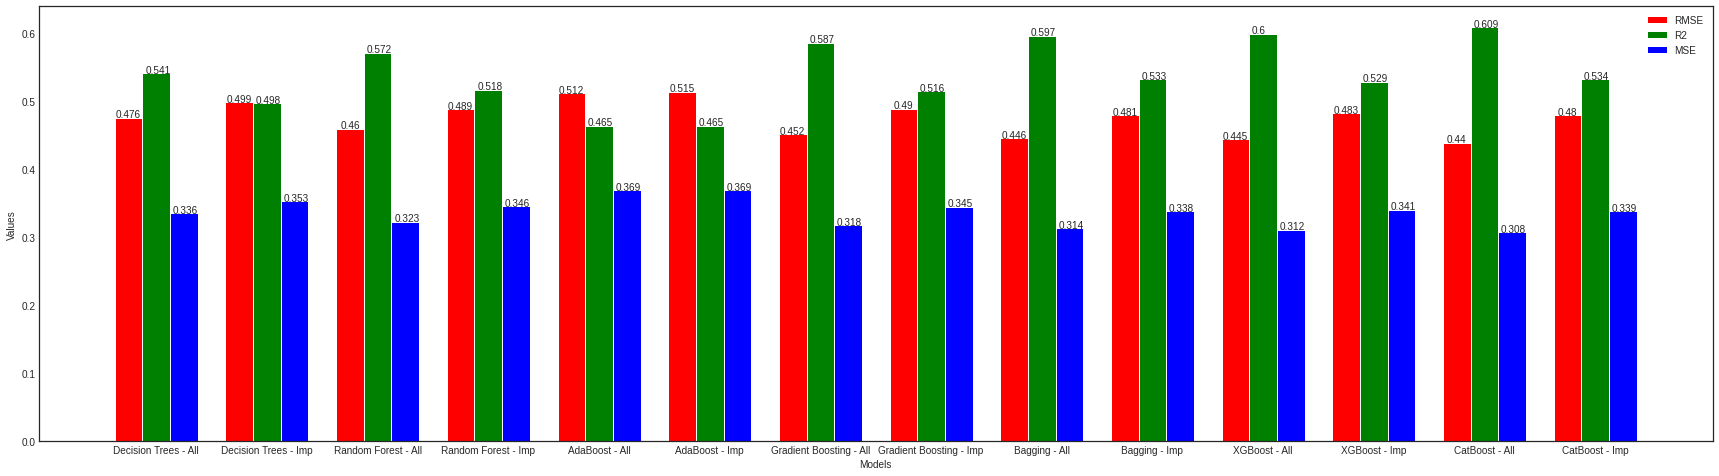

In [132]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [30, 8]

# Define the model names and the corresponding values for rmse, r2, and mean squared error
models = ['Decision Trees - All', 'Decision Trees - Imp', 'Random Forest - All', 'Random Forest - Imp', 'AdaBoost - All', 'AdaBoost - Imp', 'Gradient Boosting - All', 'Gradient Boosting - Imp', 'Bagging - All', 'Bagging - Imp', 'XGBoost - All', 'XGBoost - Imp', 'CatBoost - All', 'CatBoost - Imp']
rmse_values = [rmse_dtr_gs_all, rmse_dtr_imp, rmse_rf_gs_all, rmse_rf_imp, rmse_ada_gs_all, rmse_ada_gs_imp, rmse_gb_all, rmse_gb_imp, rmse_bagging_all, rmse_bagging_imp, rmse_xgb_all, rmse_xgb_imp, rmse_cat_all, rmse_cat_imp]
r2_values = [r2_dtr_gs_all, r2_dtr_imp, r2_rf_gs_all, r2_rf_imp ,r2_ada_gs_imp, r2_ada_gs_imp, r2_gb_all, r2_gb_imp, r2_bagging_all, r2_bagging_imp, r2_xgb_all, r2_xgb_imp, r2_cat_all, r2_cat_imp]
mae_values = [mae_dtr_gs_all, mae_dtr_imp, mae_rf_gs_all, mae_rf_imp, mae_ada_gs_imp, mae_ada_gs_imp, mae_gb_all, mae_gb_imp, mae_bagging_all, mae_bagging_imp, mae_xgb_all, mae_xgb_imp, mae_cat_all, mae_cat_imp]

# Set the width of each bar
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(rmse_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.bar(r1, rmse_values, color='r', width=bar_width, edgecolor='white', label='RMSE')
plt.bar(r2, r2_values, color='g', width=bar_width, edgecolor='white', label='R2')
plt.bar(r3, mae_values, color='b', width=bar_width, edgecolor='white', label='MSE')

# Add xticks on the middle of the group bars
plt.xlabel('Models')
plt.xticks([r + bar_width for r in range(len(rmse_values))], models)

# Add y-axis label
plt.ylabel('Values')

# Add a legend
plt.legend()

# Define a function to add data labels to the bar plot
def add_labels_rmse(values):
    for i, v in enumerate(values):
        plt.text(i, v, str(round(v,3)), ha='center')

def add_labels_r2(values):
    for i, v in enumerate(values):
        plt.text(i+0.15, v, str(round(v,3)), ha='left')

def add_labels_mae(values):
    for i, v in enumerate(values):
        plt.text(i+0.4, v, str(round(v,3)), ha='left')

# Call the function for each bar chart
add_labels_rmse(rmse_values)
add_labels_r2(r2_values)
add_labels_mae(mae_values)

# Show the chart
plt.show()

Based on Mean Absolute Error, Root Mean Squared Error and R squared, CatBoost Model with all features gives the best performance (i.e., it has the lowest mean absolute error and root mean squared error and highest r squared). On the second position, we have XGBoost Model with all features and on the third position, we have Bagging Model with all features. 

# Scenario 2: outliers are removed

### Decision Trees

#### Model with all features

In [99]:
X_train_wo, X_test_wo, y_train_wo, y_test_wo = train_test_split(X_wo_outlier, y_wo_outlier, test_size=0.3, random_state=3)

In [100]:
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
dt_parameters = [{'max_depth' : depths,
                  'min_samples_leaf' : num_leafs}]

dt_gs = GridSearchCV(DecisionTreeRegressor(), dt_parameters, scoring = 'neg_mean_absolute_error',cv = 3)
dt_gs.fit(X_train_wo,y_train_wo)

dt_gs.best_score_ 
dt_gs.best_estimator_

pred_dtr_gs_wo = dt_gs.best_estimator_.predict(X_test_wo)

In [101]:
mae_dtr_gs_all2 = mean_absolute_error(y_test_wo, pred_dtr_gs_wo)
rmse_dtr_gs_all2 = np.sqrt(mean_squared_error(y_test_wo, pred_dtr_gs_wo))
r2_dtr_gs_all2 = r2_score(y_test_wo, pred_dtr_gs_wo)
print('MAE: %f' % mae_dtr_gs_all2)
print('RMSE: %f' % rmse_dtr_gs_all2)
print('R2: %f' % r2_dtr_gs_all2)

MAE: 0.315154
RMSE: 0.414431
R2: 0.594394


#### Model with important features

In [102]:
X_pick_wo=feature_df_wo_outlier[['host_id','latitude','longitude','dummy_Entire home/apt']].to_numpy()
X_train_new_wo, X_test_new_wo, y_train_new_wo, y_test_new_wo = train_test_split(X_pick_wo, y_wo_outlier, test_size=0.3, random_state=3)

In [103]:
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
dt_parameters = [{'max_depth' : depths,
                  'min_samples_leaf' : num_leafs}]

dt_gs = GridSearchCV(DecisionTreeRegressor(), dt_parameters, scoring = 'neg_mean_absolute_error',cv = 3)
dt_gs.fit(X_train_new_wo,y_train_new_wo)

pred_dtr_gs_new_wo = dt_gs.best_estimator_.predict(X_test_new_wo)

In [104]:
mae_dtr_imp2 = mean_absolute_error(y_test_new_wo, pred_dtr_gs_new_wo)
rmse_dtr_imp2 = np.sqrt(mean_squared_error(y_test_new_wo, pred_dtr_gs_new_wo))
r2_dtr_imp2 = r2_score(y_test_new_wo, pred_dtr_gs_new_wo)
print('MAE: %f' % mae_dtr_imp2)
print('RMSE: %f' % rmse_dtr_imp2)
print('R2: %f' % r2_dtr_imp2)

MAE: 0.331955
RMSE: 0.435736
R2: 0.551621


### Random Forest

#### Model with all features

In [105]:
num_estimators = np.arange(1,10)
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
max_features = ['auto', 'log2', 'sqrt']
rf_parameters = [{
                 'n_estimators': num_estimators,
                 'max_depth' : depths,
                 'min_samples_leaf' : num_leafs,
                 'max_features' : max_features}]

rf_gs = GridSearchCV(RandomForestRegressor(), rf_parameters, scoring = 'neg_mean_absolute_error', cv = 3)
rf_gs.fit(X_train_wo,y_train_wo)

print(rf_gs.best_score_ )
print(rf_gs.best_estimator_)

pred_rf_gs_wo = rf_gs.best_estimator_.predict(X_test_wo)

-0.30375352964932717
RandomForestRegressor(max_depth=9, max_features='auto', min_samples_leaf=5,
                      n_estimators=8)


In [106]:
mae_rf_gs_all2 = mean_absolute_error(y_test_wo, pred_rf_gs_wo)
rmse_rf_gs_all2 = np.sqrt(mean_squared_error(y_test_wo, pred_rf_gs_wo))
r2_rf_gs_all2 = r2_score(y_test_wo, pred_rf_gs_wo)
print('MAE: %f' % mae_rf_gs_all2)
print('RMSE: %f' % rmse_rf_gs_all2)
print('R2: %f' % r2_rf_gs_all2)

MAE: 0.303345
RMSE: 0.399886
R2: 0.622366


#### Model with important features

In [107]:
num_estimators = np.arange(1,10)
depths = np.arange(1,10)
num_leafs = np.arange(1,10)
max_features = ['auto', 'log2', 'sqrt']
rf_parameters = [{
                 'n_estimators': num_estimators,
                 'max_depth' : depths,
                 'min_samples_leaf' : num_leafs,
                 'max_features' : max_features}]

rf_gs = GridSearchCV(RandomForestRegressor(), rf_parameters, scoring = 'neg_mean_absolute_error', cv = 3)
rf_gs.fit(X_train_new_wo,y_train_new_wo)

pred_rf_gs_new_wo = rf_gs.best_estimator_.predict(X_test_new_wo)

In [108]:
mae_rf_imp2 = mean_absolute_error(y_test_new_wo, pred_rf_gs_new_wo)
rmse_rf_imp2 = np.sqrt(mean_squared_error(y_test_new_wo, pred_rf_gs_new_wo))
r2_rf_imp2 = r2_score(y_test_new_wo, pred_rf_gs_new_wo)
print('MAE: %f' % mae_rf_imp2)
print('RMSE: %f' % rmse_rf_imp2)
print('R2: %f' % r2_rf_imp2)

MAE: 0.325615
RMSE: 0.426688
R2: 0.570049


###AdaBoost

####Model with all features

In [109]:
# Define the AdaBoost regressor to use
ada_reg3 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), random_state=3)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

# Perform grid search with cross-validation
grid_search_ada3 = GridSearchCV(ada_reg3, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_ada3.fit(X_train_wo,y_train_wo)

# Print the best hyperparameters and corresponding score
print("Best Parameters: ", grid_search_ada3.best_params_)
print("Best Score: {:.2f}".format(-grid_search_ada3.best_score_))

# Make predictions on the test data using the best estimator found by grid search
best_ada_reg3 = grid_search_ada3.best_estimator_
pred_ada_reg_gs3 = best_ada_reg3.predict(X_test_wo)

Best Parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
Best Score: 0.19


In [110]:
mae_ada_gs_all2 = mean_absolute_error(y_test_wo, pred_ada_reg_gs3)
rmse_ada_gs_all2 = np.sqrt(mean_squared_error(y_test_wo, pred_ada_reg_gs3))
r2_ada_gs_all2 = r2_score(y_test_wo, pred_ada_reg_gs3)
print('MAE: %f' % mae_ada_gs_all2)
print('RMSE: %f' % rmse_ada_gs_all2)
print('R2: %f' % r2_ada_gs_all2)

MAE: 0.349798
RMSE: 0.447397
R2: 0.527301


####Model with important features

In [111]:
# Perform grid search with cross-validation
grid_search_ada4 = GridSearchCV(ada_reg3, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_ada4.fit(X_train_new_wo,y_train_new_wo)

# Print the best hyperparameters and corresponding score
print("Best Parameters: ", grid_search_ada4.best_params_)
print("Best Score: {:.2f}".format(-grid_search_ada4.best_score_))

# Make predictions on the test data using the best estimator found by grid search
best_ada_reg4 = grid_search_ada4.best_estimator_
pred_ada_reg_gs4 = best_ada_reg4.predict(X_test_new_wo)

Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 200}
Best Score: 0.20


In [112]:
mae_ada_gs_imp2 = mean_absolute_error(y_test_new_wo, pred_ada_reg_gs4)
rmse_ada_gs_imp2 = np.sqrt(mean_squared_error(y_test_new_wo, pred_ada_reg_gs4))
r2_ada_gs_imp2 = r2_score(y_test_new_wo, pred_ada_reg_gs4)
print('MAE: %f' % mae_ada_gs_imp2)
print('RMSE: %f' % rmse_ada_gs_imp2)
print('R2: %f' % r2_ada_gs_imp2)

MAE: 0.350511
RMSE: 0.452795
R2: 0.515825


###Gradient Boosting

####Model with all features

In [113]:
# Define the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=3)

# Define the parameters to search
params_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 1.0],
    'min_samples_split': [2, 3, 4]
}

# Define the GridSearchCV object
grid_search_gb3 = GridSearchCV(estimator=gb_regressor, param_grid=params_gb, cv=3)

# Train the model with GridSearchCV
grid_search_gb3.fit(X_train_wo,y_train_wo)

# Get the best parameters and the best score
best_params3 = grid_search_gb3.best_params_
best_score3 = grid_search_gb3.best_score_

In [114]:
# Use the best parameters to train a new model
best_gb_regressor3 = GradientBoostingRegressor(**best_params3, random_state=3)
best_gb_regressor3.fit(X_train_wo,y_train_wo)

#Making predictions
pred_gb3 = best_gb_regressor3.predict(X_test_wo)

In [115]:
mae_gb_all2 = mean_absolute_error(y_test_wo, pred_gb3)
rmse_gb_all2 = np.sqrt(mean_squared_error(y_test_wo, pred_gb3))
r2_gb_all2 = r2_score(y_test_wo, pred_gb3)
print('MAE: %f' % mae_gb_all2)
print('RMSE: %f' % rmse_gb_all2)
print('R2: %f' % r2_gb_all2)

MAE: 0.298560
RMSE: 0.393612
R2: 0.634121


####Model with important features

In [116]:
# Define the GridSearchCV object
grid_search_gb4 = GridSearchCV(estimator=gb_regressor, param_grid=params_gb, cv=3)

# Train the model with GridSearchCV
grid_search_gb4.fit(X_train_new_wo,y_train_new_wo)

# Get the best parameters and the best score
best_params4 = grid_search_gb4.best_params_
best_score4 = grid_search_gb4.best_score_

In [117]:
# Use the best parameters to train a new model
best_gb_regressor4 = GradientBoostingRegressor(**best_params4, random_state=3)
best_gb_regressor4.fit(X_train_new_wo,y_train_new_wo)

#Making predictions
pred_gb4 = best_gb_regressor4.predict(X_test_new_wo)

In [118]:
mae_gb_imp2 = mean_absolute_error(y_test_new_wo, pred_gb4)
rmse_gb_imp2 = np.sqrt(mean_squared_error(y_test_new_wo, pred_gb4))
r2_gb_imp2 = r2_score(y_test_new_wo, pred_gb4)
print('MAE: %f' % mae_gb_imp2)
print('RMSE: %f' % rmse_gb_imp2)
print('R2: %f' % r2_gb_imp2)

MAE: 0.326032
RMSE: 0.426665
R2: 0.570094


###Bagging

####Model with all features

In [119]:
# Define the Gradient Boosting Regressor
bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)

# Define the parameter grid to search over
param_bagging = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Perform grid search
grid_search_bagging3 = GridSearchCV(
    estimator=bagging_regressor,
    param_grid=param_bagging,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid_search_bagging3.fit(X_train_wo,y_train_wo)

# Print the best parameters and the corresponding mean squared error
print('Best Parameters:', grid_search_bagging3.best_params_)
print('Best Score:', -grid_search_bagging3.best_score_)

# Make predictions on the test set
pred_bagging3 = grid_search_bagging3.predict(X_test_wo)

Best Parameters: {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 50}
Best Score: 0.15620393784577183


In [120]:
mae_bagging_all2 = mean_absolute_error(y_test_wo, pred_bagging3)
rmse_bagging_all2 = np.sqrt(mean_squared_error(y_test_wo, pred_bagging3))
r2_bagging_all2 = r2_score(y_test_wo, pred_bagging3)
print('MAE: %f' % mae_bagging_all2)
print('RMSE: %f' % rmse_bagging_all2)
print('R2: %f' % r2_bagging_all2)

MAE: 0.295583
RMSE: 0.391444
R2: 0.638141


####Model with important features

In [121]:
# Perform grid search
grid_search_bagging4 = GridSearchCV(
    estimator=bagging_regressor,
    param_grid=param_bagging,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
grid_search_bagging4.fit(X_train_new_wo,y_train_new_wo)

# Print the best parameters and the corresponding mean squared error
print('Best Parameters:', grid_search_bagging4.best_params_)
print('Best Score:', -grid_search_bagging4.best_score_)

# Make predictions on the test set
pred_bagging4 = grid_search_bagging4.predict(X_test_new_wo)

Best Parameters: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Best Score: 0.1793191946463092


In [122]:
mae_bagging_imp2 = mean_absolute_error(y_test_new_wo, pred_bagging4)
rmse_bagging_imp2 = np.sqrt(mean_squared_error(y_test_new_wo, pred_bagging4))
r2_bagging_imp2 = r2_score(y_test_new_wo, pred_bagging4)
print('MAE: %f' % mae_bagging_imp2)
print('RMSE: %f' % rmse_bagging_imp2)
print('R2: %f' % r2_bagging_imp2)

MAE: 0.318031
RMSE: 0.420401
R2: 0.582625


###XGBoost

####Model with all features

In [123]:
# define xgboost regressor
xgb_reg = xgb.XGBRegressor()

# define grid search parameters
params_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000]
}

# perform grid search
grid_search_xgb3 = GridSearchCV(estimator=xgb_reg, param_grid=params_xgb, cv=3, n_jobs=-1, verbose=1)
grid_search_xgb3.fit(X_train_wo,y_train_wo)

# get best parameters
best_params_xgb3 = grid_search_xgb3.best_params_

# use best parameters to train xgboost model
xgb_reg_best3 = xgb.XGBRegressor(max_depth=best_params_xgb3['max_depth'], 
                                learning_rate=best_params_xgb3['learning_rate'], 
                                n_estimators=best_params_xgb3['n_estimators'])
xgb_reg_best3.fit(X_train_wo,y_train_wo)

# make predictions
pred_xgb3  = xgb_reg_best3.predict(X_test_wo)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [124]:
mae_xgb_all2 = mean_absolute_error(y_test_wo, pred_xgb3)
rmse_xgb_all2 = np.sqrt(mean_squared_error(y_test_wo, pred_xgb3))
r2_xgb_all2 = r2_score(y_test_wo, pred_xgb3)
print('MAE: %f' % mae_xgb_all2)
print('RMSE: %f' % rmse_xgb_all2)
print('R2: %f' % r2_xgb_all2)

MAE: 0.293875
RMSE: 0.388357
R2: 0.643827


####Model with important features

In [125]:
# perform grid search
grid_search_xgb4 = GridSearchCV(estimator=xgb_reg, param_grid=params_xgb, cv=3, n_jobs=-1, verbose=1)
grid_search_xgb4.fit(X_train_new_wo,y_train_new_wo)

# get best parameters
best_params_xgb4 = grid_search_xgb4.best_params_

# use best parameters to train xgboost model
xgb_reg_best4 = xgb.XGBRegressor(max_depth=best_params_xgb4['max_depth'], 
                                learning_rate=best_params_xgb4['learning_rate'], 
                                n_estimators=best_params_xgb4['n_estimators'])
xgb_reg_best4.fit(X_train_new_wo,y_train_new_wo)

# make predictions
pred_xgb4  = xgb_reg_best4.predict(X_test_new_wo)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [126]:
mae_xgb_imp2 = mean_absolute_error(y_test_new_wo, pred_xgb4)
rmse_xgb_imp2 = np.sqrt(mean_squared_error(y_test_new_wo, pred_xgb4))
r2_xgb_imp2 = r2_score(y_test_new_wo, pred_xgb4)
print('MAE: %f' % mae_xgb_imp2)
print('RMSE: %f' % rmse_xgb_imp2)
print('R2: %f' % r2_xgb_imp2)

MAE: 0.321577
RMSE: 0.421670
R2: 0.580101


###CatBoost

####Model with all features

In [127]:
# Define the parameter grid for the GridSearch
param_grid_cat = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [100, 500, 1000]}

# Define the CatBoostRegressor model
model = CatBoostRegressor(verbose=False)

# Perform the GridSearch
grid_search_cat3 = GridSearchCV(estimator=model, param_grid=param_grid_cat, cv=3, n_jobs=-1)
grid_search_cat3.fit(X_train_wo,y_train_wo)

# Print the best parameters found by the GridSearch
print(grid_search_cat3.best_params_)

# Make predictions on the test set using the best model
pred_cat3 = grid_search_cat3.predict(X_test_wo)

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.05}


In [128]:
mae_cat_all2 = mean_absolute_error(y_test_wo, pred_cat3)
rmse_cat_all2 = np.sqrt(mean_squared_error(y_test_wo, pred_cat3))
r2_cat_all2 = r2_score(y_test_wo, pred_cat3)
print('MAE: %f' % mae_cat_all2)
print('RMSE: %f' % rmse_cat_all2)
print('R2: %f' % r2_cat_all2)

MAE: 0.289908
RMSE: 0.383934
R2: 0.651894


####Model with important features

In [129]:
# Perform the GridSearch
grid_search_cat4 = GridSearchCV(estimator=model, param_grid=param_grid_cat, cv=3, n_jobs=-1)
grid_search_cat4.fit(X_train_new_wo,y_train_new_wo)

# Print the best parameters found by the GridSearch
print(grid_search_cat4.best_params_)

# Make predictions on the test set using the best model
pred_cat4 = grid_search_cat4.predict(X_test_new_wo)

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.05}


In [130]:
mae_cat_imp2 = mean_absolute_error(y_test_new_wo, pred_cat4)
rmse_cat_imp2 = np.sqrt(mean_squared_error(y_test_new_wo, pred_cat4))
r2_cat_imp2 = r2_score(y_test_new_wo, pred_cat4)
print('MAE: %f' % mae_cat_imp2)
print('RMSE: %f' % rmse_cat_imp2)
print('R2: %f' % r2_cat_imp2)

MAE: 0.318795
RMSE: 0.418706
R2: 0.585984


##Comparison of all Models' Performances

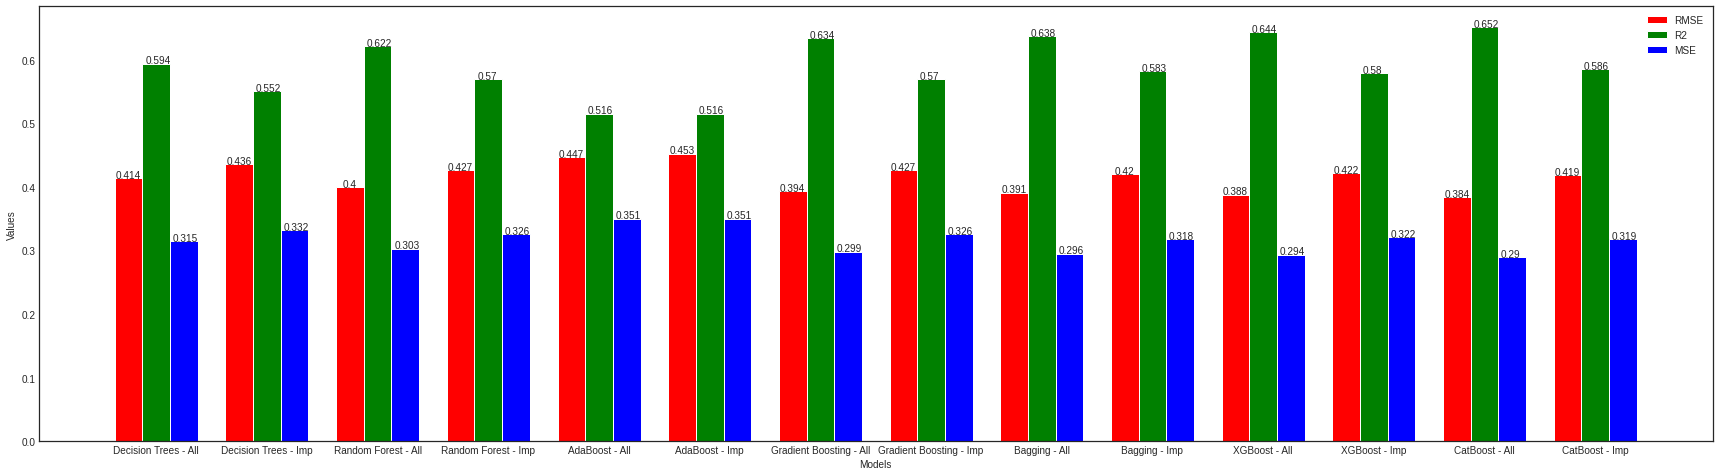

In [131]:
# Define the model names and the corresponding values for rmse, r2, and mean squared error
models = ['Decision Trees - All', 'Decision Trees - Imp', 'Random Forest - All', 'Random Forest - Imp', 'AdaBoost - All', 'AdaBoost - Imp', 'Gradient Boosting - All', 'Gradient Boosting - Imp', 'Bagging - All', 'Bagging - Imp', 'XGBoost - All', 'XGBoost - Imp', 'CatBoost - All', 'CatBoost - Imp']
rmse_values = [rmse_dtr_gs_all2, rmse_dtr_imp2, rmse_rf_gs_all2, rmse_rf_imp2, rmse_ada_gs_all2, rmse_ada_gs_imp2, rmse_gb_all2, rmse_gb_imp2, rmse_bagging_all2, rmse_bagging_imp2, rmse_xgb_all2, rmse_xgb_imp2, rmse_cat_all2, rmse_cat_imp2]
r2_values = [r2_dtr_gs_all2, r2_dtr_imp2, r2_rf_gs_all2, r2_rf_imp2, r2_ada_gs_imp2, r2_ada_gs_imp2, r2_gb_all2, r2_gb_imp2, r2_bagging_all2, r2_bagging_imp2, r2_xgb_all2, r2_xgb_imp2, r2_cat_all2, r2_cat_imp2]
mae_values = [mae_dtr_gs_all2, mae_dtr_imp2, mae_rf_gs_all2, mae_rf_imp2, mae_ada_gs_imp2, mae_ada_gs_imp2, mae_gb_all2, mae_gb_imp2, mae_bagging_all2, mae_bagging_imp2, mae_xgb_all2, mae_xgb_imp2, mae_cat_all2, mae_cat_imp2]

# Set the width of each bar
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(rmse_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.bar(r1, rmse_values, color='r', width=bar_width, edgecolor='white', label='RMSE')
plt.bar(r2, r2_values, color='g', width=bar_width, edgecolor='white', label='R2')
plt.bar(r3, mae_values, color='b', width=bar_width, edgecolor='white', label='MSE')

# Add xticks on the middle of the group bars
plt.xlabel('Models')
plt.xticks([r + bar_width for r in range(len(rmse_values))], models)

# Add y-axis label
plt.ylabel('Values')

# Add a legend
plt.legend()
plt.rcParams['figure.figsize'] = [30, 8]

# Define a function to add data labels to the bar plot
def add_labels_rmse(values):
    for i, v in enumerate(values):
        plt.text(i, v, str(round(v,3)), ha='center')

def add_labels_r2(values):
    for i, v in enumerate(values):
        plt.text(i+0.15, v, str(round(v,3)), ha='left')

def add_labels_mae(values):
    for i, v in enumerate(values):
        plt.text(i+0.4, v, str(round(v,3)), ha='left')

# Call the function for each bar chart
add_labels_rmse(rmse_values)
add_labels_r2(r2_values)
add_labels_mae(mae_values)

# Show the chart
plt.show()

Based on Mean Absolute Error, Root Mean Squared Error and R squared, CatBoost Model with all features gives the best performance (i.e., it has the lowest mean absolute error and root mean squared error and highest r squared). On the second position, we have XGBoost Model with all features and on the third position, we have Bagging Model with all features.

#Conclusion

The best 3 models in both the scenarios are exactly same. Now let's compare at the models' performance across both the scenarios as well.

Based on the performance indicators of the regression model (i.e., mean absolute error, root mean squared error, and R squared), the top 5 models across both the scenarios are mentioned below:

1. CatBoost Model with all features (Without Outliers)
2. XGBoost Model with all features (Without Outliers)
3. Bagging Model with all features (Without Outliers)
4. Gradient Model with all features (Without Outliers)
5. Random Forest Model with all features (Without Outliers)

From this one can also conclude, that removing outliers and taking all the features give us better results, in general. 